<a href="https://colab.research.google.com/github/azfarkhoja305/GANs/blob/super-resolution/TGenerator_SuperResolution_MSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
from pathlib import Path
import functools 
import math
import pdb

Path.ls = lambda x: list(x.iterdir())

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchsummary import summary

In [3]:
!git clone https://github.com/azfarkhoja305/GANs.git

fatal: destination path 'GANs' already exists and is not an empty directory.


In [4]:
if Path('./GANs').exists():
    sys.path.insert(0,'./GANs')

In [5]:
from datasets import ImageDataset
from utils.utils import check_gpu, display_images

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
device = check_gpu()
print(f'Using device: {device}')

Using device: cuda


In [8]:
from utils.layers import LinearReshape
from models.transformer_generator import TGenerator

In [9]:
TGen = TGenerator().to(device)

In [10]:
bottom_width, embed_chs =  TGen.bottom_width, TGen.embed_chs
ct_in_layer = LinearReshape(in_dims=3, out_dims=embed_chs//4,
                            width=bottom_width*2, embed_chs=embed_chs//4)

In [11]:
TGenerator.ct_in_layer = ct_in_layer.to(device)
# python magic :)
hasattr(TGen, "ct_in_layer")

True

In [12]:
def super_resolution(self, x):
    """ Start from the 2nd stage of the Generator for now. """
    # Push channels to last dimention and project
    x = self.ct_in_layer(x.permute(0,2,3,1)) 
    for i, blocks in enumerate(self.upsample_block):
        if i == 0:   # skip upsample
             x = x + self.pos_embed[i+1]
        else:    x = self.pixel_upsample[i](x) + self.pos_embed[i+1]
        for blk in blocks:
            x  = blk(x)
    x = self.to_rgb(x)
    return x.contiguous()

In [13]:
TGenerator.super_resolution = super_resolution
hasattr(TGen, "super_resolution")

True

In [14]:
# Sanity check shapes
with torch.no_grad():
    sample_img_batch = torch.randn(16,3,16,16).to(device)
    recovered_img = TGen.super_resolution(sample_img_batch)
    print(recovered_img.shape)

torch.Size([16, 3, 32, 32])


In [15]:
def reduce_resolution(image_batch):
    """ Function to reduce the resolution of an image by half. """
    return F.interpolate(image_batch, scale_factor=0.5, mode='bilinear',
                          align_corners=False, recompute_scale_factor=False)

In [ ]:
dataset =  ImageDataset('cifar_10', batch_sz = 64)

In [41]:
@torch.no_grad()
def pass_one_batch():
    targ_img = next(iter(dataset.valid_loader))[0]
    lowres_img = reduce_resolution(targ_img.to(device))
    gen_img = TGen.super_resolution(lowres_img)

    improved_img_grid = vutils.make_grid(gen_img.cpu(), padding=2, normalize=True)
    target_img_grid = vutils.make_grid(targ_img.cpu(), padding=2, normalize=True)
    lowres_img_grid = vutils.make_grid(lowres_img.cpu(), padding=2, normalize=True)
    return lowres_img_grid, improved_img_grid, targ_img

In [46]:
lowres_img_grid, improved_img_grid, targ_img = pass_one_batch()

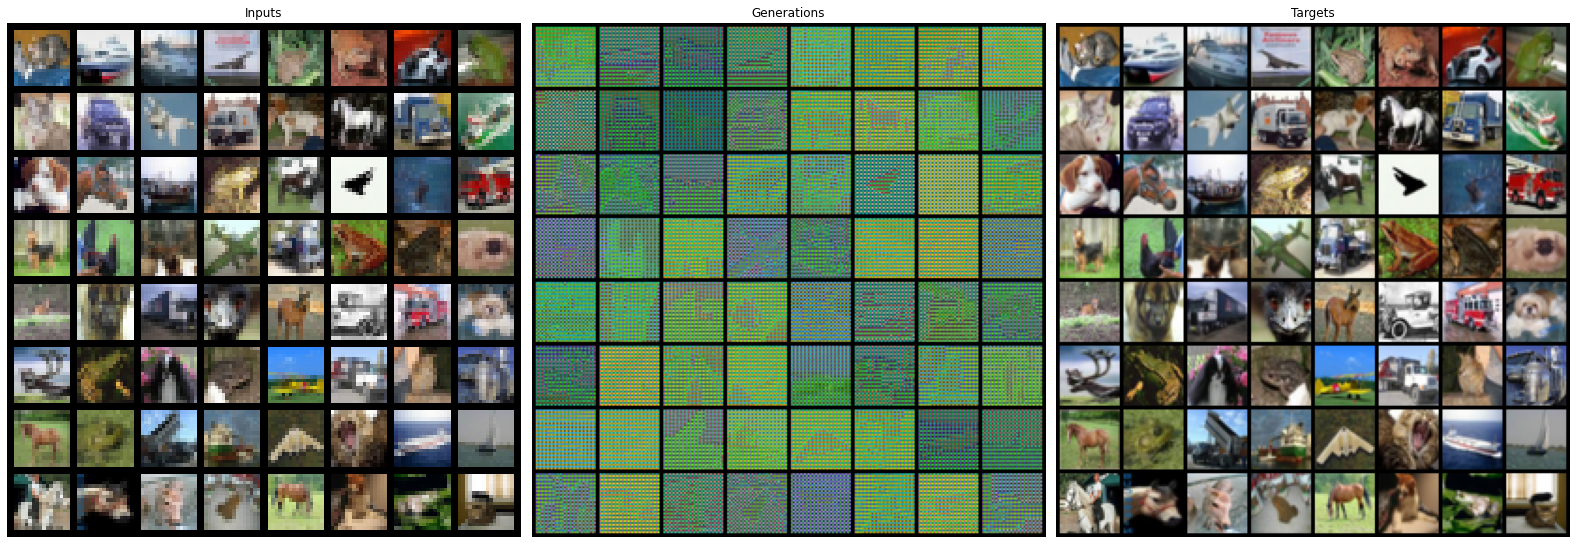

In [47]:
# before training plots
_, axs = plt.subplots(1,3,figsize=(22,20))
display_images([lowres_img_grid], ax = axs[0], title='Inputs')
display_images([improved_img_grid], ax = axs[1], title='Generations')
display_images([target_img_grid], ax = axs[2], title = 'Targets')
plt.tight_layout()

In [ ]:
class LossMetric():
    """ Average loss statistics over an entire epoch """
    def __init__(self):
        self.loss = 0
        self.num = 0
    def update_state(self,loss,num):
        assert num > 0, f'num elements = {num}, needs to be greater than zero'
        # since incoming loss is averaged
        self.loss += loss * num
        self.num +=num
    def result(self):
        assert self.num > 0, f'num = {num}, needs to be greater than zero'
        # avg loss for one epoch = total loss / total number of samples
        return self.loss / self.num
    def reset_state(self):
        self.loss = 0
        self.num = 0

In [ ]:
# hyper params
lr = 1e-4
optimizer = optim.AdamW(TGen.parameters(), lr=lr, betas=(0.9, 0.999))
loss_fn = nn.MSELoss(reduction='mean')

num_epochs=20

In [ ]:
# store loss statistics
logs = {'train_loss': [], 'valid_loss': []}
train_loss_metric = LossMetric()
valid_loss_metric = LossMetric()

gen_img_list = []

In [ ]:
print(f'Epoch\t Train Loss \t Valid Loss')
for epoch in range(num_epochs):MA
    TGen.train()
    train_loss_metric.reset_state()
    for target_img,_ in tqdm(dataset.train_loader, leave=False):
        target_img = target_img.to(device)
        low_res_img = reduce_resolution(target_img)
        generated_img = TGen.super_resolution(low_res_img)
        loss = loss_fn(generated_img, target_img)
        train_loss_metric.update_state(loss.item(), target_img.shape[0])
        TGen.zero_grad()
        loss.backward()
        optimizer.step()
    
    TGen.eval()
    valid_loss_metric.reset_state()
    for target_img, _ in tqdm(dataset.valid_loader, leave=False):
        target_img = target_img.to(device)
        with torch.no_grad():
            low_res_img = reduce_resolution(target_img)
            generated_img = TGen.super_resolution(low_res_img)
            loss = loss_fn(generated_img, target_img)
            valid_loss_metric.update_state(loss.item(), target_img.shape[0])
    
    print(f'{epoch}\t {train_loss_metric.result():.5f}\t {valid_loss_metric.result():.5f}')
    logs['train_loss'].append(train_loss_metric.result())
    logs['valid_loss'].append(valid_loss_metric.result())
    # save to see improvement after each epoch on valid_set
    gen_img_list.append(vutils.make_grid(generated_img.cpu(), padding=2, normalize=True))

In [34]:
lowres_img_grid, improved_img_grid, targ_img = pass_one_batch()

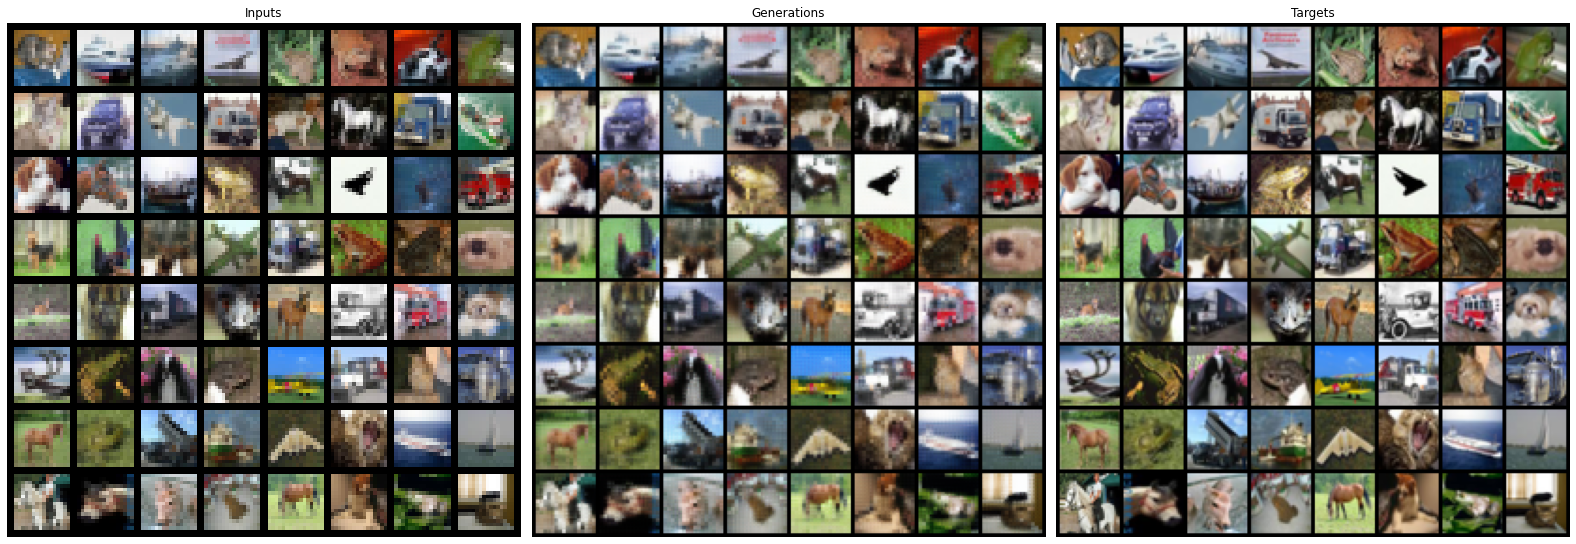

In [35]:
# after training plots
_, axs = plt.subplots(1,3,figsize=(22,20))
display_images([lowres_img_grid], ax = axs[0], title='Inputs')
display_images([improved_img_grid], ax = axs[1], title='Generations')
display_images([target_img_grid], ax = axs[2], title = 'Targets')
plt.tight_layout()

Some images get Horizontally Flipped (first image, man on horse).  Weird!!

ohh, we randomly flip our input images. So for that particular batch, they were flipped before going into the network :b

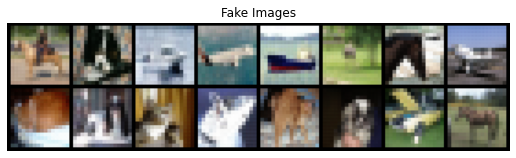

In [28]:
display_images([gen_img_list[5]])

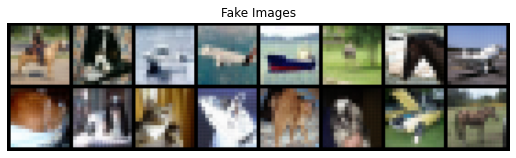

In [29]:
display_images([gen_img_list[15]])

In [25]:
# rc('animation', html='jshtml')
# fig = plt.figure(figsize=(8,8))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in gen_img_list]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
# ani